# IT3212 - Assignment 2

## Config

In [1]:
run_eda = False
lemmatize = False
with_sentiment = False

## Importing libraries

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import re
import string

# NLTK tools and datasets
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim

# Uncomment if you need to download NLTK data packages
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

# Text processing
from textblob import TextBlob
import contractions

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, auc)
from sklearn.model_selection import cross_val_predict

# Miscellaneous
from collections import Counter
from urllib.parse import unquote
from scipy import stats
import chardet


### Fix dataset encoding issues

In [3]:
# Some rows in the raw data include non UTF-8 characters. 

# Example of text with non UTF-8 characters:
# 778245336,FALSE,finalized,5,8/30/15 13:27,Not Relevant,0.7952,,army,
# text column: Pakistan,".: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: RT DrAyesha4: #IndiaKoMunTorJawabDo Indian Army ki��_ http://t.co/WJLJq3yA4g"
# ,6.29079E+17,195397186

# Chardet identifies the encoding of the raw data as 'MacRoman'.
# For now, we will remove all non UTF-8 characters from the raw data
# We handle this by removing all � characters from the raw data and writing the modified content back to the file.

def fix_non_utf8_encoding(filepath, destination_filepath):
    with open(filepath, 'rb') as file:
        rawdata = file.read()
        result = chardet.detect(rawdata)
        print(result['encoding'])


    # Open the file in read mode, read its contents, then close it
    with open('data/disaster-tweets.csv', 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Remove all � characters
    content = content.replace('�', '')

    # Open the file in write mode and write the modified content back to it
    with open(destination_filepath, 'w', encoding='utf-8') as file:
        file.write(content)

filepath = 'data/disaster-tweets.csv'
dest = 'data/disaster-tweets-utf8.csv'

# fix_non_utf8_encoding(filepath, dest)

In [4]:
def split_train_test(filepath):
    df = pd.read_csv(filepath, encoding='utf-8')
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)
    return train_data, test_data

filepath = 'data/disaster-tweets-utf8.csv'

### Importing dataset

In [5]:
import_remote = False

if import_remote:
    df_train = pd.read_csv('https://raw.githubusercontent.com/magnusrodseth/it3212/main/data/train.csv', encoding='utf-8')
    df_test = pd.read_csv('https://raw.githubusercontent.com/magnusrodseth/it3212/main/data/test.csv', encoding='utf-8')
else:
    df_train, df_test = split_train_test(filepath)

df_train.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just rem...,6.291070e+17,2.327739e+08
1,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishi...,6.290180e+17,2.750220e+07
2,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIx...,6.290920e+17,6.052387e+08
3,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exch...,6.291190e+17,2.305930e+09
4,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's s...,6.290800e+17,2.464266e+07


##  Exploratory data analysis (EDA)

In [6]:
# print all rows where keyword is 'wreckagec
pd.set_option('display.max_colwidth', None)
df_train[df_train['keyword'] == 'explode'].sort_values(by='choose_one', ascending=False).head(1000)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
6850,778249699,False,finalized,5,9/1/15 4:45,Relevant,0.6084,NaN,explode,"Washington, D.C.",Kendall Jenner and Nick Jonas Are Dating and the World Might Quite Literally Explode http://t.co/pfvzVPxQGr,6.290870e+17,3.346248e+08
3807,778249678,False,finalized,5,9/1/15 15:45,Relevant,0.6024,NaN,explode,"Pea Ridge, WV",@wyattmccab you'd throw a can of Copenhagen wintergreen on the ground that would explode on your enemies and give them mouth cancer,6.290920e+17,2.654272e+08
4203,778249703,False,finalized,5,8/29/15 12:05,Relevant,0.8001,NaN,explode,NaN,im sooooooo full my stomach is going to explode,6.290840e+17,2.759442e+09
6725,778249712,False,finalized,5,8/28/15 20:10,Relevant,0.6030,NaN,explode,NaN,@allen_enbot If you mess up it's gonna explode...,6.290930e+17,2.904779e+08
81,778249685,False,finalized,5,8/31/15 3:17,Not Relevant,0.8012,NaN,explode,London / Berlin / Online,'I eat because it makes my mouth explode with joy and my soul rise upwards.' ~ http://t.co/mOdM8X1Ot9 http://t.co/oSsC7Q12iR,6.290790e+17,2.316803e+09
3954,778249695,False,finalized,5,8/27/15 18:10,Not Relevant,0.7982,NaN,explode,"Spring Grove, IL",If Schwarber ran into me going that fast I would explode into pieces,6.290800e+17,1.261018e+09
5447,778249705,False,finalized,5,8/29/15 9:55,Not Relevant,0.7990,NaN,explode,"Yamaku Academy, Class 3-4",Versions of KS where if a character was /every/ character world would explode.\n\nRin\nShizune\nMisha\nEmi\nKenji\nYuuko\nNomiya\nHisao,6.290790e+17,2.484396e+09
5620,778249714,False,finalized,5,8/30/15 13:25,Not Relevant,1.0000,NaN,explode,"Cleveland, TN",VINE OF THE YEAR OH MY GOD I AM ABOUT TO EXPLODE https://t.co/cnxXmfFRae,6.290870e+17,8.545018e+08
6508,778249692,False,finalized,5,8/30/15 9:02,Not Relevant,1.0000,NaN,explode,"Yamaku Academy, Class 3-4",KS except every character is Shizune.\nThe world would explode.,6.290790e+17,2.484396e+09
6915,778249726,False,finalized,5,8/28/15 4:29,Not Relevant,1.0000,NaN,explode,New Hampshire,@DelDryden If I press on the twitch will my head explode?,6.290840e+17,1.546260e+07


In [7]:
if run_eda:
    # Clean `keyword` column.

    # Write the updated dataframe to a new CSV file
    # Plot the most common keywords
    defined_keywords = df_train[df_train['keyword'] != '']['keyword']

    plt.figure()
    sns.countplot(y=defined_keywords, order=defined_keywords.value_counts().iloc[:10].index)
    plt.title('Most Common Keywords')
    plt.xlabel('Count')
    plt.ylabel('Keyword')
    plt.tight_layout()
    plt.show()

In [8]:
if run_eda:
    # Compare keywords for disaster tweets and non-disaster tweets
    disaster_keywords = df_train[df_train['choose_one'] == 'Relevant']['keyword']
    non_disaster_keywords = df_train[df_train['choose_one'] == 'Not Relevant']['keyword']

    # Create a figure object and define the grid
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plotting
    sns.countplot(y=disaster_keywords, ax=ax[0], order=disaster_keywords.value_counts().iloc[:10].index, color='red')
    sns.countplot(y=non_disaster_keywords, ax=ax[1], order=non_disaster_keywords.value_counts().iloc[:10].index, color='blue')

    # Titles and labels
    ax[0].set_title('Most Common Keywords for Disaster Tweets')
    ax[0].set_xlabel('Count')
    ax[0].set_ylabel('Keyword')

    ax[1].set_title('Most Common Keywords for Non-Disaster Tweets')
    ax[1].set_xlabel('Count')
    ax[1].set_ylabel('Keyword')

    # Adjust layout
    plt.tight_layout()
    plt.show()



In the plot above, we can see that the top 10 shared keywords of disaster-related tweets and non-disaster-related tweets do not share any common keywords.

## 1. Preprocessing

In [9]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def filter_rows_by_confidence_and_decision(df, confidence_threshold):
    df = df[df['choose_one:confidence'] >= confidence_threshold]
    df = df[df['choose_one'] != "Can't Decide"]
    return df

def map_choose_one_to_y(df):
    df['target'] = df['choose_one'].apply(lambda choice: 1 if choice == 'Relevant' else 0)
    return df

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    if lemmatize:
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    text = contractions.fix(text)
    text = ' '.join(tokenizer.tokenize(text))
    return text

def clean_keyword(keyword):
    return unquote(keyword) if pd.notnull(keyword) else ''

def clean_data(df):
    df['keyword'] = df['keyword'].apply(clean_keyword).apply(str.lower)
    df['text_raw'] = df['text']
    df['text'] = df['text'].apply(clean_text)
    return df

initial_count = df_train.shape[0]
confidence_threshold = 0.7

df_train = filter_rows_by_confidence_and_decision(df_train, confidence_threshold)
print("Removed {} of total: {} rows. Remaining rows: {}".format(initial_count - df_train.shape[0], initial_count, df_train.shape[0]))

features_to_keep = ['target', 'text', 'keyword']

df_train = map_choose_one_to_y(df_train)
df_train = df_train[features_to_keep]
df_train = clean_data(df_train)

count_initial = df_train.shape[0]
df_train = df_train.drop_duplicates(subset=['text'])
print("Removed {} duplicated rows.".format(count_initial - df_train.shape[0]))


# Preprocess the test data as well
df_test = map_choose_one_to_y(df_test)
df_test = df_test[features_to_keep]
df_test = clean_data(df_test)

df_test.head()


Removed 2167 of total: 8700 rows. Remaining rows: 6533
Removed 635 duplicated rows.


,target,text,keyword,text_raw
0,1,sunset looked like erupting volcano initial thought pixar short lava,volcano,The sunset looked like an erupting volcano .... My initial thought was the Pixar short Lava http://t.co/g4sChqFEsT
1,1,7294 nikon d50 61 mp digital slr camera body 2 batteries carry bag charger 20000,body bag,#7294 Nikon D50 6.1 MP Digital SLR Camera Body 2 batteries carry bag and charger http://t.co/SL7PHqSGKV\n\n$200.00\n_ http://t.co/T4Qh2OM8Op
2,0,mentaltwitter note make sure smoke alarm battery snuff times face many twitter reminders changing battery,smoke,Mental/Twitter Note: Make sure my smoke alarm battery is up to snuff at all times or face many twitter reminders of changing my battery.
3,0,emergency need part 2 3 nashnewvideo nashgrier 103,emergency,?????? EMERGENCY ?????? NEED PART 2 and 3!!! #NashNewVideo http://t.co/TwdnNaIOns @Nashgrier 103
4,0,whelen model 295ss100 siren amplifier police emergency vehicle full read ebay,siren,WHELEN MODEL 295SS-100 SIREN AMPLIFIER POLICE EMERGENCY VEHICLE - Full read by eBay http://t.co/Q3yYQi4A27 http://t.co/whEreofYAx


## 2. Extracting features

### Miscellanous features from `text` column

In [10]:
def extract_features(df): 
    # Create new column for text length
    df['text_length'] = df['text_raw'].apply(len)
    # Extract the number of hashtags
    df["hashtag_count"] = df["text_raw"].apply(lambda x: len([c for c in str(x) if c == "#"]))

    # Extract the number of mentions
    df["mention_count"] = df["text_raw"].apply(lambda x: len([c for c in str(x) if c == "@"]))

    # Extract the `has_url` feature
    df["has_url"] = df["text_raw"].apply(lambda x: 1 if "http" in str(x) else 0)
    return df

# Write the updated dataframe to a CSV file
df_train = extract_features(df_train)
df_test = extract_features(df_test)
df_train.head()

,target,text,keyword,text_raw,text_length,hashtag_count,mention_count,has_url
0,0,do not even remember slsp happening remember like wtf lights turned everyone screamed encore,screamed,i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore,134,0,0,0
1,0,hazelannmac ooh feel guilty wishing hatman bet mudslide delicious,mudslide,@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!,94,0,1,0
2,0,soultech collide club mix,collide,Soultech - Collide (Club Mix) http://t.co/8xIxBsPOT8,52,0,0,1
3,1,police officer wounded suspect dead exchanging shots,wounded,Police Officer Wounded Suspect Dead After Exchanging Shots - http://t.co/iPHaZV47g7,83,0,0,1
4,0,cramer igers 3 words wrecked disneys stock,wrecked,Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/4dGpBAiVL7,73,0,0,1


### Ngrams

In [11]:
def create_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return ['_'.join(ngram) for ngram in n_grams]

def add_ngrams_to_text(text):
    bigrams_string = ' '.join(create_ngrams(text, 2))
    trigrams_string = ' '.join(create_ngrams(text, 3))
    return text + ' ' + bigrams_string + ' ' + trigrams_string

def add_ngrams_to_df(df):
    df['text_with_ngrams'] = df['text'].apply(add_ngrams_to_text)
    return df

# Apply to DataFrames
df_train = add_ngrams_to_df(df_train)
df_test = add_ngrams_to_df(df_test)

# print full rows
pd.set_option('display.max_colwidth', None)
df_train[['text_with_ngrams', 'text_raw']].head(2)

,text_with_ngrams,text_raw
0,do not even remember slsp happening remember like wtf lights turned everyone screamed encore do_not not_even even_remember remember_slsp slsp_happening happening_remember remember_like like_wtf wtf_lights lights_turned turned_everyone everyone_screamed screamed_encore do_not_even not_even_remember even_remember_slsp remember_slsp_happening slsp_happening_remember happening_remember_like remember_like_wtf like_wtf_lights wtf_lights_turned lights_turned_everyone turned_everyone_screamed everyone_screamed_encore,i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore
1,hazelannmac ooh feel guilty wishing hatman bet mudslide delicious hazelannmac_ooh ooh_feel feel_guilty guilty_wishing wishing_hatman hatman_bet bet_mudslide mudslide_delicious hazelannmac_ooh_feel ooh_feel_guilty feel_guilty_wishing guilty_wishing_hatman wishing_hatman_bet hatman_bet_mudslide bet_mudslide_delicious,@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!


### Embedding `text` using `TF-IDF`

In [58]:
vectorizer = TfidfVectorizer(max_features=1000)

feature_to_embed = 'text_with_ngrams'

# Fit and transform the training data
text_embedded = vectorizer.fit_transform(df_train[feature_to_embed])
df_train_text_embedded_tfidf = pd.DataFrame(text_embedded.toarray(), columns=vectorizer.get_feature_names_out(), index=df_train.index)

# Transform the test data using the same vectorizer
text_embedded_test = vectorizer.transform(df_test[feature_to_embed])
df_test_text_embedded_tfidf = pd.DataFrame(text_embedded_test.toarray(), columns=vectorizer.get_feature_names_out(), index=df_test.index)

### Embedding `text` column using `Word2Vec`

#### Config

In [41]:
w2v_conifig = {
    "vector_size": 200,
    "with_ngrams": True
}

#### Create model

In [40]:
if w2v_conifig['with_ngrams']:
    tokenized_text = df_train['text_with_ngrams'].apply(lambda x: x.split())
else:
    tokenized_text = df_train['text'].apply(lambda x: x.split())

import gensim.downloader as api
model_w2v = api.load("glove-twitter-200")

# model_w2v = gensim.models.Word2Vec(
#             tokenized_text,
#             vector_size=w2v_conifig['vector_size'], # desired no. of features/independent variables
#             window=5, # context window size
#             min_count=2, # Ignores all words with total frequency lower than 2.                                  
#             sg = 1, # 1 for skip-gram model, 0 for CBOW
#             negative = 10, # for negative sampling
#             workers= 8, # no.of cores
#             seed = 34
# ) 

# # https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314
# # Skip-gram: works well with a small amount of the training data, represents well even rare words or phrases.
# # CBOW: several times faster to train than the skip-gram, slightly better accuracy for the frequent words.

# model_w2v.train(tokenized_text, total_examples= len(df_train), epochs=100)


[==================================================] 100.0% 758.5/758.5MB downloaded


#### Create embeddings from `text`

In [51]:
def embed_text_feature(df, col, model, vector_size):
    def tokens_to_vectors(text_tokens) -> np.ndarray:
        vectors = np.zeros((len(text_tokens), vector_size))

        # embed each token (word-ish) in the text. If the token is not in the model's vocabulary, embed it as a zero vector.
        for i, token in enumerate(text_tokens):
            try:
                vectors[i] = model[token]
            except KeyError:  # Token not in the model's vocabulary
                vectors[i] = np.zeros(vector_size)

        # if all tokens were zero vectors, i.e. all words not in the model's vocabulary, return a zero vector
        if np.all(vectors == 0):
            return np.zeros(vector_size)
        
        return vectors.mean(axis=0)

    embeddings = []
    for tokens in df[col].apply(lambda x: x.split()):
        embeddings.append(tokens_to_vectors(tokens))

    return pd.DataFrame(np.vstack(embeddings), columns=[f'{col}_w2v_{i}' for i in range(vector_size)])

df_train_text_embedded_w2v = embed_text_feature(df_train, 'text', model_w2v, w2v_conifig['vector_size'])
df_test_text_embedded_w2v = embed_text_feature(df_test, 'text', model_w2v, w2v_conifig['vector_size'])

df_train_text_embedded_w2v.shape

(5898, 200)

In [43]:
model_w2v.most_similar(positive=['asshole'], topn=1000)

[('faggot', 0.7595045566558838),
 ('fucker', 0.7343282103538513),
 ('cunt', 0.7339721918106079),
 ('dumbass', 0.7336857914924622),
 ('assholes', 0.7178757786750793),
 ('dick', 0.7010302543640137),
 ('twat', 0.6922847032546997),
 ('bastard', 0.6884879469871521),
 ('douchebag', 0.6879569888114929),
 ('whore', 0.6878525018692017),
 ('dickhead', 0.6844528913497925),
 ('fucks', 0.6765825748443604),
 ('bitch', 0.6759504079818726),
 ('prick', 0.6721539497375488),
 ('dude', 0.6716276407241821),
 ('dumb', 0.6688453555107117),
 ('rude', 0.6668071150779724),
 ('stupid', 0.6635216474533081),
 ('jerk', 0.6621419787406921),
 ('fag', 0.6608372330665588),
 ('loser', 0.6606627106666565),
 ('motherfucker', 0.6590434312820435),
 ('ass', 0.6563829183578491),
 ('slut', 0.6563006639480591),
 ('suck', 0.6557682752609253),
 ('fucked', 0.6481084227561951),
 ('fucking', 0.6472057104110718),
 ('person', 0.6469531655311584),
 ('stfu', 0.6460312604904175),
 ('shut', 0.6458073258399963),
 ('guy', 0.6448845267295837

### Embed `keyword` column using one-hot encoding

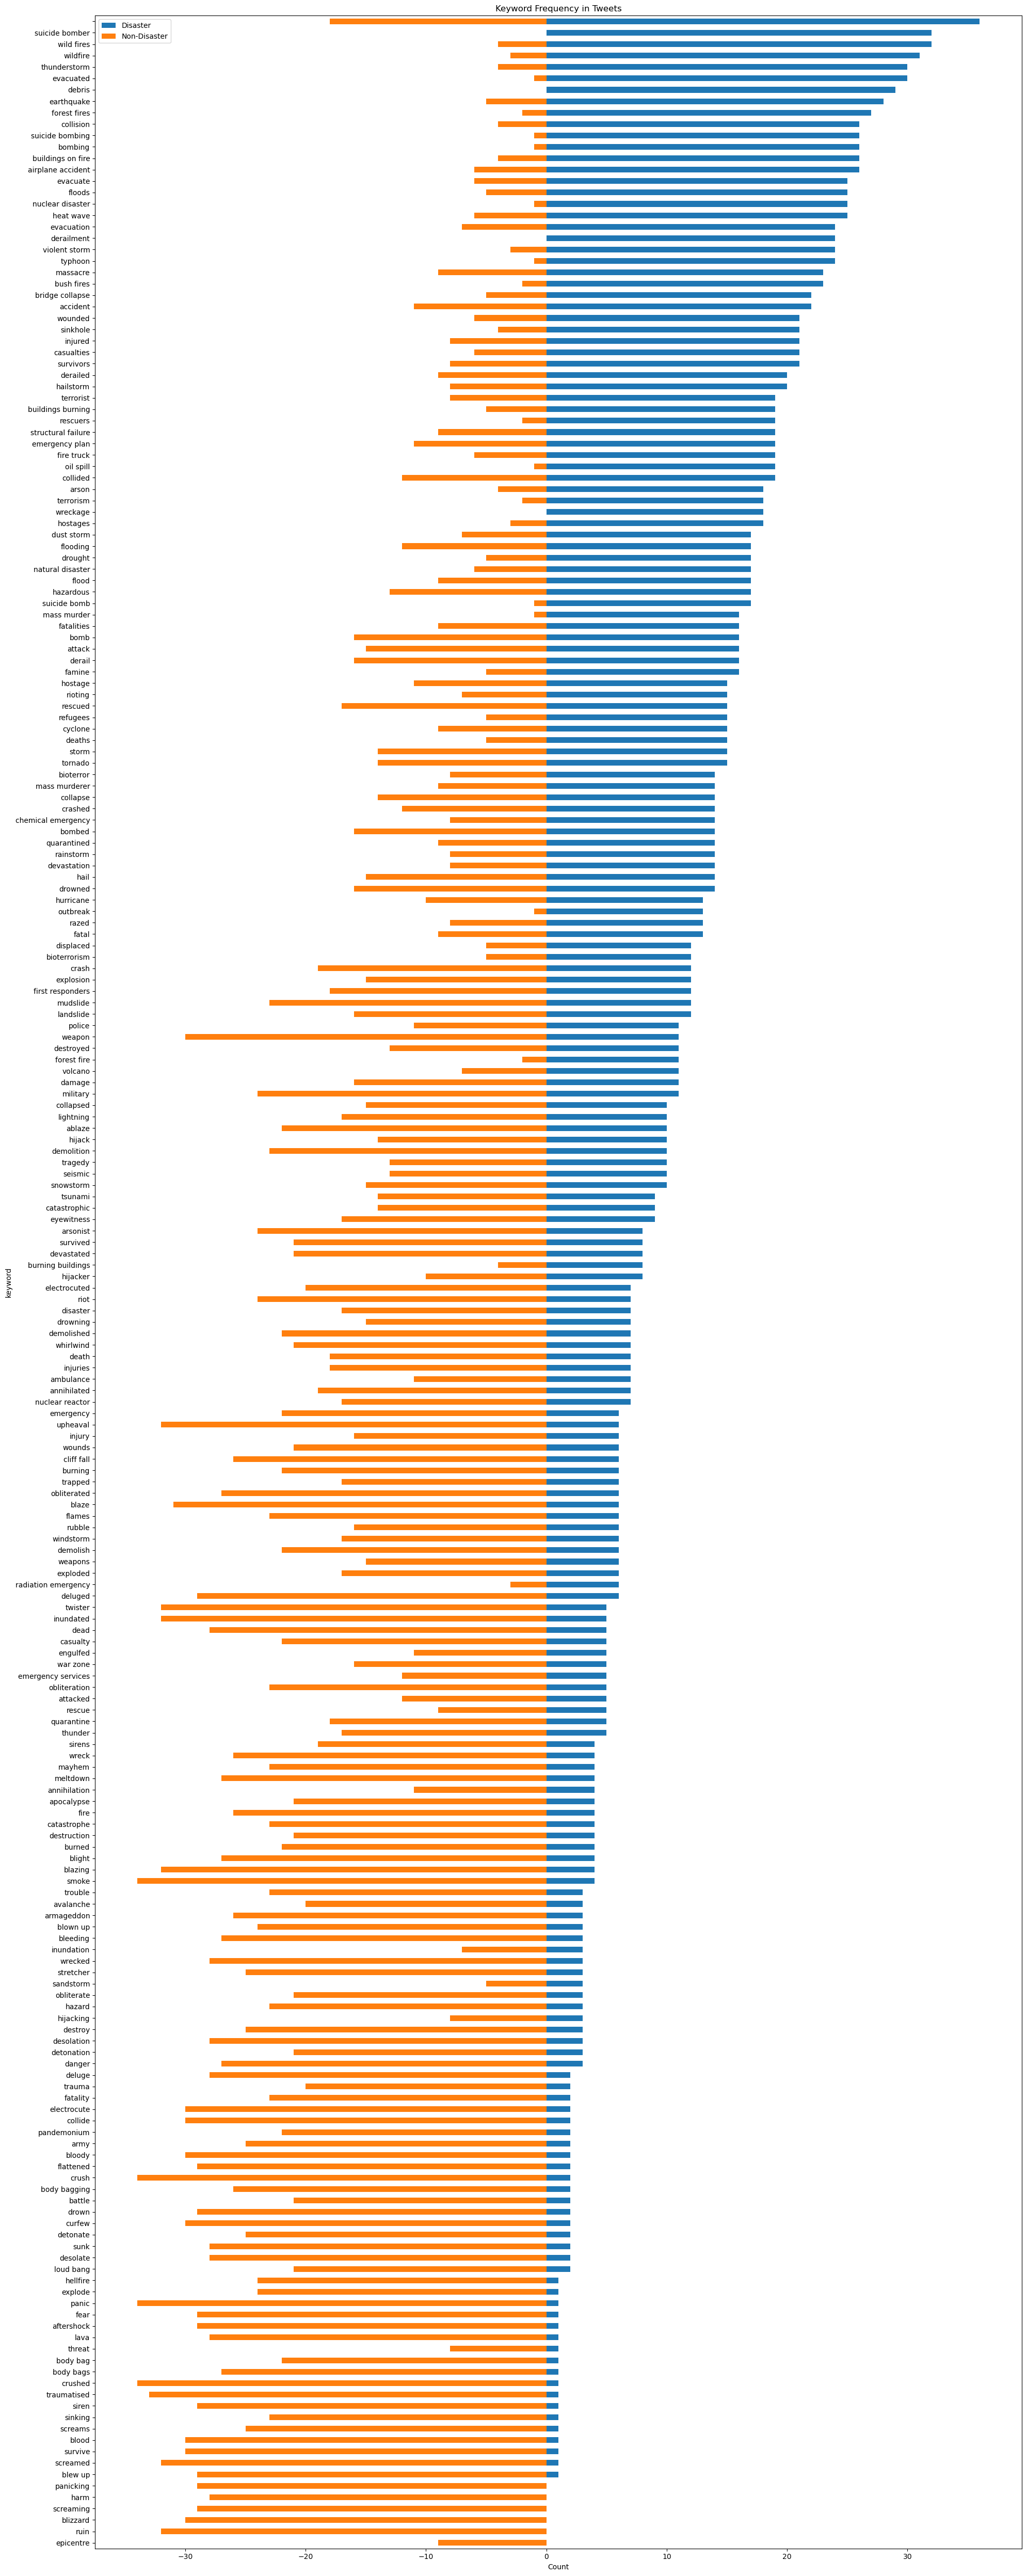

In [ ]:
# Count the frequency of each keyword for disaster and non-disaster tweets
disaster_keyword_counts = df_train[df_train['target'] == 1]['keyword'].value_counts()
non_disaster_keyword_counts = df_train[df_train['target'] == 0]['keyword'].value_counts()

# Combine the counts into one DataFrame
combined_counts = pd.DataFrame({
    'Disaster': disaster_keyword_counts,
    'Non-Disaster': -non_disaster_keyword_counts  # Negate for leftward extension
})

# Fill NaN values with 0
combined_counts = combined_counts.fillna(0)

combined_counts.sort_values(by='Disaster').plot(kind='barh', stacked=True, figsize=(20, 50))
plt.xlabel('Count')
plt.title('Keyword Frequency in Tweets')
plt.tight_layout()
plt.show()

In [ ]:
# print all rows where keyword is 'wreckage'
pd.set_option('display.max_colwidth', None)
df_train[df_train['keyword'] == 'explode'][['text_raw', 'keyword', 'target']].head(100)

,text_raw,keyword,target
81,'I eat because it makes my mouth explode with joy and my soul rise upwards.' ~ http://t.co/mOdM8X1Ot9 http://t.co/oSsC7Q12iR,explode,0
670,It's cold and my head wants to explode.. The joys of working from home - I'm going back to bed / peace out ????,explode,0
728,My brains going to explode i need to leave this house. Ill be out smoking packs if you need me,explode,0
918,what if i want to fuck the duck until explode. it could be greasy,explode,0
1160,@magicallester I will die. I'm actually being serious. My heart will beat so fast it will fly out off my chest &amp; explode,explode,0
1296,Block the plate with a charging Schwarber coming down the line Cervelli. I dare you. You would explode into a little puff of smoke,explode,0
1348,happy Justin makes my heart explode,explode,0
1950,If Ryan doesn't release new music soon I might explode,explode,0
2131,Learn How I Gained Access To The Secrets Of The Top Earners &amp; Used Them To Explode My Home Business Here: http://t.co/e84IFMCczN Please #RT,explode,0
2361,After having two cans explode I wanted to drink the rest but these ... (Kaldi Coffee Stout) http://t.co/u6isXv2F3V #photo,explode,0


## 3. Selecting features

In [52]:
df_train.columns

Index(['target', 'text', 'keyword', 'text_raw', 'text_length', 'hashtag_count',
       'mention_count', 'has_url', 'text_with_ngrams'],
      dtype='object')

In [59]:
features_to_keep = ['target', 'text_length', 'hashtag_count', 'mention_count', 'has_url']

X_train = pd.concat([
    df_train[features_to_keep], 
    # df_train_text_embedded_w2v,
    df_train_text_embedded_tfidf
    ], axis=1)
X_test = pd.concat([
    df_test[features_to_keep], 
    # df_test_text_embedded_w2v,
    df_test_text_embedded_tfidf
    ], axis=1)

X_train.dropna(inplace=True)

# extract y_train and y_test here to avoid column name collision with 'target' feature coming from text and keyword embeddings
y_train = X_train['target']
y_test = X_test['target']

X_train.drop(['target'], axis=1, inplace=True)
X_test.drop(['target'], axis=1, inplace=True)

X_train.shape

(5898, 1004)

## 4. Modelling

In [60]:
logreg = True
svm = False
xgb = True
rforest = False

In [61]:
def print_results(y_pred, y_train, y_pred_test, y_test):
    print("Train results")
    print("-----------------------------")
    print("Train accuracy: {}".format(accuracy_score(y_train, y_pred)))
    print(classification_report(y_train, y_pred))
    print(confusion_matrix(y_train, y_pred))

    print()
    print("Test results")
    print("-----------------------------")
    print("Test accuracy: {}".format(accuracy_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))
    print(confusion_matrix(y_test, y_pred_test))


### 4.1 Logistic regression

In [64]:
if logreg:
    logreg = LogisticRegression(random_state=42, solver="liblinear")
    logreg.fit(X_train, y_train)

    y_pred = cross_val_predict(logreg, X_train, y_train, cv=5)  # 5-fold cross-validation
    y_pred_test = logreg.predict(X_test)

    print_results(y_pred, y_train, y_pred_test, y_test)

Train results
-----------------------------
Train accuracy: 0.8450322143099356
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3596
           1       0.84      0.74      0.79      2302

    accuracy                           0.85      5898
   macro avg       0.84      0.83      0.83      5898
weighted avg       0.84      0.85      0.84      5898

[[3280  316]
 [ 598 1704]]

Test results
-----------------------------
Test accuracy: 0.7867647058823529
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1219
           1       0.81      0.67      0.74       957

    accuracy                           0.79      2176
   macro avg       0.79      0.77      0.78      2176
weighted avg       0.79      0.79      0.78      2176

[[1068  151]
 [ 313  644]]


In [88]:
# test manual prediction

test_df = pd.DataFrame({
    'text': ['car crash accident explosion fire'],
    'keyword': 'test',
})

test_df = clean_data(test_df)
test_df = extract_features(test_df)
test_df = add_ngrams_to_df(test_df)

feature_to_embed = 'text_with_ngrams'
vectors = vectorizer.transform(test_df[feature_to_embed])
text_embedded = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out(), index=test_df.index)

display(test_df)

# drop text_raw and text_with_ngrams
test_df.drop(['text_raw', 'text_with_ngrams', 'keyword', 'text'], axis=1, inplace=True)

test_df = pd.concat([
    test_df,
    text_embedded
    ], axis=1)

y_pred_test = logreg.predict_proba(test_df)

print(y_pred_test)

,text,keyword,text_raw,text_length,hashtag_count,mention_count,has_url,text_with_ngrams
0,car crash accident explosion fire,test,car crash accident explosion fire,33,0,0,0,car crash accident explosion fire car_crash crash_accident accident_explosion explosion_fire car_crash_accident crash_accident_explosion accident_explosion_fire


[[0.16828021 0.83171979]]


### 4.1.2. Support Vector Machines

In [36]:
if svm:
    first_n = 1000

    # Initialize SVM model
    svm_model = SVC(kernel='linear', C=1, random_state=42, probability=False)

    # Fit the model on training data
    svm_model.fit(X_train, y_train)

    # Use 5-fold cross-validation to get predictions on training set
    y_pred_train = cross_val_predict(svm_model, X_train, y_train, cv=5)
    y_pred_test = svm_model.predict(X_test)

    print_results(y_pred_train, y_train, y_pred_test, y_test)

In [63]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Creating an XGBoost classifier
model = xgb.XGBClassifier()

# Training the model on the training data
model.fit(X_train, y_train)

# Making predictions on the test set
predictions_test = model.predict(X_test)

# Calculating accuracy on test set
accuracy_test = accuracy_score(y_test, predictions_test)

# Making predictions on the training set
predictions_train = model.predict(X_train)

# Calculating accuracy on training set
accuracy_train = accuracy_score(y_train, predictions_train)

print("Test Set Metrics:")
print("Accuracy:", accuracy_test)
print("\nClassification Report:")
print(classification_report(y_test, predictions_test))

print("\nTraining Set Metrics:")
print("Accuracy:", accuracy_train)
print("\nClassification Report:")
print(classification_report(y_train, predictions_train))


Test Set Metrics:
Accuracy: 0.7844669117647058

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1219
           1       0.84      0.63      0.72       957

    accuracy                           0.78      2176
   macro avg       0.80      0.77      0.77      2176
weighted avg       0.79      0.78      0.78      2176


Training Set Metrics:
Accuracy: 0.8999660902000678

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      3596
           1       0.96      0.77      0.86      2302

    accuracy                           0.90      5898
   macro avg       0.92      0.88      0.89      5898
weighted avg       0.91      0.90      0.90      5898



In [ ]:
if rforest:
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))



In [ ]:
# catboost

import catboost as cb
from catboost import CatBoostClassifier, Pool

# Initialize CatBoostClassifier

model = CatBoostClassifier(iterations=2,
                            learning_rate=1,
                            depth=2,
                            loss_function='Logloss',
                            verbose=True)

# Fit model
model.fit(X_train, y_train)

# Get predicted classes
preds_class = model.predict(X_test)

# print results
print("Accuracy:", accuracy_score(y_test, preds_class))
print("\nClassification Report:")
print(classification_report(y_test, preds_class))




0:	learn: 0.6196796	total: 1.54ms	remaining: 1.54ms
1:	learn: 0.6131165	total: 2.25ms	remaining: 0us
Accuracy: 0.6410845588235294

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1219
           1       0.60      0.55      0.57       957

    accuracy                           0.64      2176
   macro avg       0.63      0.63      0.63      2176
weighted avg       0.64      0.64      0.64      2176



In [ ]:
# Import Adaboost
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100, random_state=0)
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))